In [112]:
%run /home/dbaciur/NTU/NTU/notes/Constants.ipynb

Constants loaded


This is the very first attempt to train network which was later replaced by automated tests runner in Python part of the project

In [113]:
import torch
import numpy
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

LABELS_MAP = {
    1: 0,
    7: 1,
    8: 2,
    13: 3,
    14: 4,
    15: 5,
    16: 6,
    22: 7,
    23: 8
}

# Review dataset

In [114]:
# Load frames df
frames_df = pd.read_csv(C.Frames.FRAMES_DF_DRAFT_PATH, converters=C.F_CONVERTERS)
frames_df.head(1)

,Event id,Video,Time,Frame name,Behaviors,Layout
0,NaN,PH1011-PHYSICS_20150922,65.873,PH1011-PHYSICS_20150922__Time65.873sec,[999],3.0


## Check example frame

In [115]:
frame_file = frames_df.iloc[0][C.F_FRAME_NAME]
frame_file

'PH1011-PHYSICS_20150922__Time65.873sec'

In [116]:
frame = torch.load(f"{C.Frames.FRAMES_SCREENSHOTS_PATH}/{frame_file}.pt")
frame.shape

torch.Size([1, 720, 1440, 3])

## Check example views

In [117]:
# Load views df
views_df = pd.read_csv(C.VIEWS_DF_PATH, converters=C.V_CONVERTERS)
views_df.head(1)

,Id,Event id,Video,Frame name,View names,View behaviors,View layouts
0,0,NaN,PH1011-PHYSICS_20150922,PH1011-PHYSICS_20150922__Time65.873sec,"[PH1011-PHYSICS_20150922__Time65.873sec_VLeft,...",[999],"[1, 1]"


In [118]:
frame_view_names =  views_df[views_df[C.F_FRAME_NAME] == frame_file]
frame_view_names = frame_view_names[C.V_VIEWS]
frame_view_names[0]

['PH1011-PHYSICS_20150922__Time65.873sec_VLeft',
 'PH1011-PHYSICS_20150922__Time65.873sec_VRight']

In [119]:
# let's analyze only 1 view
frame_view_name = frame_view_names[0][0]
frame_view_name

'PH1011-PHYSICS_20150922__Time65.873sec_VLeft'

#### AlexNet

In [9]:
alex_view = torch.load(f"{C.ALEX_NET_PATH}/{frame_view_name}.pt")[0]
alex_view.shape

torch.Size([1, 4096])

#### DeepAlexNet

In [10]:
deep_alex_view = torch.load(f"{C.DEEP_ALEX_NET_PATH}/{frame_view_name}.pt")[0]
deep_alex_view.shape

torch.Size([1, 1000])

#### ResNet

In [11]:
resnet_view = torch.load(f"{C.RES_NET_PATH}/{frame_view_name}.pt")[0]
resnet_view.shape

torch.Size([1, 2048])

#### VGG

In [12]:
vgg_view = torch.load(f"{C.VGG_PATH}/{frame_view_name}.pt")[0]
vgg_view.shape

torch.Size([1, 4096])

#### Deep VGG

In [13]:
deep_vgg_view = torch.load(f"{C.DEEP_VGG_PATH}/{frame_view_name}.pt")[0]
deep_vgg_view.shape

torch.Size([1, 25088])

### Summing up

**Video**:
<br>
data/Processed/VID.mp4


**Frames**:
<br>
[1, 720, 1440, 3] <- can be different
<br>
Frames/VID__Time{time}sec.pt


**View**:
* data/Views/{}/VID__Time{time}sec__VFull.pt

or:
* data/Views/{}/VID__Time{time}sec__VLeft.pt
* data/Views/{}/VID__Time{time}sec__VRight.pt

# Prepare samples

In [108]:
class Sample():
    def __init__(self, id, event_id, video, views, label):
        self.id = id
        self.event_id = event_id
        self.video = video
        self.views = views
        self.label = label

In [109]:
def aggregate_dict_list_values(d):
    values = set()
    for dlist in d.values():
        for item in dlist:
            values.add(item)
    return values

def subtract_lists(list1, list2):
    return [item for item in list1 if item not in list2]

def lists_intersect(list1, list2):
    for item1 in list1:
        if item1 in list2:
            return True
    return False

def get_view_ids_that_have_relevant_behs(views_df, relevant_behs):
    ids = []
    for i, row in views_df.iterrows():
        id = row[C.V_ID]
        behs = row[C.V_BEH]
        
        do_lists_interset = lists_intersect(behs, relevant_behs)
        if do_lists_interset:
            ids.append(id)
    return ids

def create_samples(views_dir, beh_labels_dict):
    # this will be the resul
    samples = []
    
    # get all behaviors to consider
    all_behs = aggregate_dict_list_values(beh_labels_dict)
    
    views_df = pd.read_csv(C.VIEWS_DF_PATH, converters=C.V_CONVERTERS)
    
    # filter out all views that does not have any relevant behaviors
    ids_of_relevant_views = get_view_ids_that_have_relevant_behs(views_df, all_behs)
    views_df= views_df[views_df[C.V_ID].isin(ids_of_relevant_views)]
    
    # for every label -> [behaviors] mapping
    for label, label_behs in tqdm(beh_labels_dict.items()):
        
        # get all behaviors that are NOT dedicated for given label
        other_behs = subtract_lists(all_behs, label_behs)

        # for every view
        for i, views_row in views_df.iterrows():

            id = views_row[C.V_ID]
            event_id = views_row[C.V_EVENT_ID]
            video = views_row[C.V_VIDEO]
            behs = views_row[C.V_BEH]

            # leave only behs that we're interested in
            behs = [beh for beh in behs if beh in all_behs]
            
            # if view doesn't have at least 1 label behavior we skip it
            behs_for_label = [beh for beh in behs if beh in label_behs]
            if len(behs) == 0:
                continue
            
            # if view has even 1 other behavior we also skip it
            has_other_beh = lists_intersect(behs, other_behs)
            if has_other_beh:
                continue

            label = torch.tensor(label)

            view_names = views_row[C.V_VIEWS]
            view_name1 = view_names[0]
            view_name2 = view_name1 if len(view_names) == 1 else view_names[1]

            view1 = torch.load(f"{views_dir}/{view_name1}.pt")[0]
            if view_name2 == view_name1:
                view2 = view1
            else:
                view2 = torch.load(f"{views_dir}/{view_name2}.pt")[0]

            views = torch.cat([view1, view2])

            samples.append(Sample(id, event_id, video, views, label))

    return samples

In [110]:
class SamplesDataset(torch.utils.data.Dataset):
    
    def __init__(self, samples, allowed_ids=None):
        super(SamplesDataset, self).__init__()
        
        self.index_to_id = {}
        self.items_dict = {}
        self.length = 0
        
        current_index = 0
        
        for index, sample in enumerate(samples):
            if allowed_ids is None or sample.id in allowed_ids:
                self.index_to_id[current_index] = sample.id
                self.items_dict[sample.id] = sample
                
                current_index = current_index + 1
                self.length = self.length + 1
    
    def get_all_ids(self):
        return list(self.index_to_id.values())
            
    def get_by_id(self, id):
        return self.items_dict[id]
    
    def __len__(self):
        return len(self.items_dict)
    
    def __getitem__(self, idx):
        if idx >= self.length:
            raise IndexError

        id = self.index_to_id[idx]
        return self.items_dict[id]

In [111]:
samples = create_samples(C.ALEX_NET_PATH, {
    0: [C.B_CHARTS_S],
    1: [C.B_EMPTY, C.B_WEBSITE_S, C.B_FILMS_S, C.B_WRITING]
})

/home/bjastrze/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [77]:
len(samples)

6802

In [95]:
sd = SamplesDataset(samples)

In [96]:
len(sd)

6802

In [98]:
views, label = sd[0].views, sd[0].label

In [99]:
print(views.shape)
print(label)

torch.Size([2, 4096])
tensor(0)


In [100]:
def get_labels_distribution(labels):
    count_dict = {}
    for label in labels:
        label = label.item()
        if count_dict.get(label) is None:
            count_dict[label] = 0
        count_dict[label] = count_dict[label] + 1
    return count_dict

In [101]:
all_labels = [item.label for item in ds]
labels_count = get_labels_distribution(all_labels)
labels_count

{0: 1001, 1: 5801}

# Train, test, validation sets

In [102]:
all_items_ids = list(train_set.get_all_ids())
all_items_count = len(all_items_ids)
all_items_count

6802

In [103]:
def split_into_sets(items, percentages):
    items = np.array(items)
    numpy.random.shuffle(items)
    
    splits = []
    
    length = len(items)
    current_index = 0
    
    for p in percentages:
        last_index = current_index + int(p * length)
        
        split = items[current_index:last_index]
        splits.append(split)
        
        current_index = last_index
    
    return splits

In [104]:
splits = split_into_sets(all_items_ids, [.5, .3, .2])

In [105]:
print(len(splits))
length = 0
for s in splits:
    length = length + len(s)
    print(len(s))
print(length)

3
3401
2040
1360
6801


In [106]:
train_ds = SamplesDataset(samples, splits[0])
test_ds = SamplesDataset(samples, splits[1])
validation_ds = SamplesDataset(samples, splits[2])

In [107]:
print(len([s for s in train_ds]))
print(len([s for s in test_ds]))
print(len([s for s in validation_ds]))

3401
2040
1360


# Architecture model

In [186]:
class SiameseEncoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SiameseEncoder, self).__init__()
        
        # Layers
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.activation1 = torch.nn.LeakyReLU()
        
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation2 = torch.nn.LeakyReLU()
        
        self.linear3 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation3 = torch.nn.LeakyReLU()
                
    def forward(self, X):
        """
        X.shape = (time, number_of_views, input_size)
        """
        
        X = self.activation1(self.linear1(X))
        X = self.activation2(self.linear2(X))
        X = self.activation3(self.linear3(X))
        
        return X      

In [187]:
class Classifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Classifier, self).__init__()
        
        # Layers
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.activation1 = torch.nn.LeakyReLU()
        
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation2 = torch.nn.LeakyReLU()
         
#         self.linear3 = torch.nn.Linear(hidden_size, output_size)
#         self.activation3 = torch.nn.Sigmoid();

        self.linear3 = torch.nn.Linear(hidden_size, output_size)
        self.activation3 = torch.nn.LeakyReLU()
        
    def forward(self, X):
        """
        X.shape = (time, input_size)
        """
        
        X = self.activation1(self.linear1(X))
        X = self.activation2(self.linear2(X))
#         X = self.activation3(self.linear3(X))
        X = self.linear3(X)
        
#         return X
        return X

In [188]:
class FeatureClassifier(torch.nn.Module):
    def __init__(self, input_size, encoder_hidden_size, classifier_hidden_size, output_size):
        '''
        Init method.
        '''
        super(FeatureClassifier, self).__init__()
        
        # Siamese Network
        self.encoder = SiameseEncoder(input_size, encoder_hidden_size, encoder_hidden_size)
        
        # Pooling both
        self.mp = torch.nn.MaxPool1d(2)
        
        # Classifier layer
        self.classifier = Classifier(encoder_hidden_size, classifier_hidden_size, output_size)
        
    def forward(self, X):
        '''
        X.shape = (batch, views, encoding_size)
        '''
        X = self.encoder(X).permute(0,2,1)
        X = self.mp(X).squeeze(2)
        X = self.classifier(X)
        
        return X

# Training

In [189]:
import copy

In [190]:
nn = FeatureClassifier(input_size=4096,
                       encoder_hidden_size=2048,
                       classifier_hidden_size=2048,
                       output_size=9).to('cpu')

In [191]:
train_loader = torch.utils.data.DataLoader(train, batch_size=200, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=200, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test, batch_size=200, shuffle=False)

In [192]:
opt = torch.optim.Adam(nn.parameters(), lr=0.001, weight_decay = 1e-2)

In [193]:
loss = torch.nn.CrossEntropyLoss()

In [194]:
X, y = next(iter(train_loader))

In [195]:
print(X.shape)
print(y)
y.shape

torch.Size([200, 2, 4096])
tensor([2, 2, 2, 7, 2, 7, 2, 4, 2, 6, 2, 4, 7, 6, 3, 3, 0, 7, 2, 6, 2, 1, 4, 4,
        1, 4, 4, 7, 4, 6, 4, 0, 2, 3, 2, 1, 2, 2, 4, 2, 2, 7, 2, 4, 2, 5, 2, 4,
        2, 7, 2, 2, 4, 1, 2, 4, 1, 2, 2, 7, 1, 7, 2, 1, 2, 4, 2, 2, 1, 7, 1, 1,
        7, 5, 6, 6, 3, 5, 7, 4, 4, 1, 2, 4, 4, 4, 4, 6, 2, 2, 4, 1, 6, 6, 5, 4,
        4, 4, 2, 3, 6, 5, 8, 6, 2, 3, 5, 2, 1, 2, 2, 6, 4, 2, 7, 2, 2, 4, 5, 5,
        6, 0, 4, 6, 4, 5, 4, 1, 2, 1, 2, 2, 2, 4, 7, 4, 2, 1, 4, 6, 2, 5, 7, 1,
        4, 2, 6, 7, 6, 2, 4, 6, 4, 1, 5, 4, 4, 4, 4, 2, 0, 1, 6, 2, 2, 4, 6, 2,
        2, 2, 6, 1, 3, 4, 2, 4, 1, 2, 2, 4, 2, 2, 5, 6, 7, 4, 4, 4, 5, 2, 0, 4,
        0, 4, 6, 4, 1, 4, 3, 2])


torch.Size([200])

In [196]:
pred = nn(X.to('cpu'))
print(pred.shape)
pred

torch.Size([200, 9])


tensor([[ 0.0061,  0.0212, -0.0205,  ...,  0.0046,  0.0342, -0.0081],
        [ 0.0018,  0.0164, -0.0186,  ..., -0.0084,  0.0404, -0.0104],
        [ 0.0077,  0.0073, -0.0161,  ..., -0.0181,  0.0352, -0.0127],
        ...,
        [ 0.0016,  0.0069, -0.0226,  ..., -0.0007,  0.0318, -0.0153],
        [ 0.0036,  0.0136, -0.0159,  ..., -0.0030,  0.0357, -0.0181],
        [-0.0018,  0.0197, -0.0239,  ...,  0.0018,  0.0381, -0.0089]],
       grad_fn=<AddmmBackward>)

In [197]:
loss(pred, y)

tensor(2.1983, grad_fn=<NllLossBackward>)

In [198]:
nn = FeatureClassifier(input_size=4096,
                       encoder_hidden_size=2048,
                       classifier_hidden_size=2048,
                       output_size=9).to('cuda')

In [199]:
train_epoch_loss_chart = []
train_batch_loss_chart = []
valid_epoch_loss_chart = []

EPOCHS = 500
pbar = tqdm(range(EPOCHS))

last_epoch_loss = 0
valid_loss = 0
best_valid_loss = float('inf')
best_model = copy.deepcopy(nn.state_dict())
for epoch in pbar:
    
    # Reset epoch_loss
    epoch_loss = 0 
    counter = 0
    for X, y in train_loader:
        
        # Cuda
        torch.cuda.empty_cache()
        
        # Zero gradient
        opt.zero_grad()
        
        # Make prediction
        pred = nn(X.to('cuda'))
        
        # Calculate loss
        batch_loss = loss(pred, y.to('cuda'))
        
        # Backpropagation
        batch_loss.backward()
        
        # Opt step
        opt.step()
        
        # Update epoch_loss
        batch_loss_value = batch_loss.detach().item()
        epoch_loss += batch_loss_value
        
        # Add batch loss
        train_batch_loss_chart.append(batch_loss_value)
        
        # Print Losses
        epoch_loss_result = round(len(train_loader)*epoch_loss/(counter+1),1)
        valid_loss_result = round(valid_loss, 1)
        progress = round(counter/len(train_loader)*100, 1)
        pbar.set_description(f'EL: {epoch_loss_result}, VL: {valid_loss_result}, Progress: {progress}%')
        
        # Update counter
        counter += 1
        
    
    # Update last
    last_epoch_loss = epoch_loss
    
    # Update chart
    train_epoch_loss_chart.append(epoch_loss)
    
    # Validation Dataset
    
    # Valid data
    valid_loss = 0
    for X, y in valid_loader:
        valid_loss += loss(nn(X.to('cuda')), y.to('cuda')).detach().item()
    valid_loss *= (len(train)/len(valid))
    
    # Saving Best Result:
    if valid_loss < best_valid_loss:
        best_model = copy.deepcopy(nn.state_dict())
        best_valid_loss = valid_loss
    
    # Valid chart
    valid_epoch_loss_chart.append(valid_loss)

EL: 50.7, VL: 51.6, Progress: 95.7%: 100%|██████████| 500/500 [03:49<00:00,  2.18it/s]


# Analysis of performance per class

In [152]:
import math

In [153]:
pred = []
true = []
for X, y in train_loader:
    pred.append(nn(X.to('cuda')).to('cpu'))
    true.append(y)
where_equal = torch.cat(pred).max(1)[1] == torch.cat(true)

In [154]:
# Prediction shape is 200 (batch size) times the number of possible classes
pred[0].shape

torch.Size([200, 2048])

In [155]:
torch.cat(pred).shape

torch.Size([4486, 2048])

In [156]:
# Example prediction
p = pred[0][0]
print(p.shape)
p

torch.Size([2048])


tensor([-0.0124,  0.0083, -0.0140,  ...,  0.0112,  0.0233,  0.0323],
       grad_fn=<SelectBackward>)

In [157]:
max_pred = torch.cat(pred).max(1)
max_pred

torch.return_types.max(
values=tensor([0.0464, 0.0499, 0.0526,  ..., 0.0474, 0.0554, 0.0549],
       grad_fn=<MaxBackward0>),
indices=tensor([1711, 1711,  598,  ..., 1711, 1711, 1711]))

In [158]:
zeros = torch.zeros(9,9)
zeros.shape

torch.Size([9, 9])

In [159]:
zeros

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [160]:
def measure_performance(nn, loader):
    pred = []
    true = []
    for X, y in loader:
        pred.append(nn(X.to('cuda')).to('cpu'))
        true.append(y)
    where_equal = torch.cat(pred).max(1)[1] == torch.cat(true)
    
    # Accuracy
    acc = where_equal.float().mean().item()
    
    # Recall 
    recall = [where_equal[torch.cat(true) == i].float().mean().item() for i in range(9)]
    
    # Balanced accuracy 
    bacc = sum(recall)/len(recall)
    
    # Precision 
    precision = [0 if math.isnan(f) else f for f in [where_equal[torch.cat(pred).max(1)[1] == i].float().mean().item() for i in range(9)]]
    
    # Matrix of returns
    odp = torch.zeros(9,9)
    predicted = torch.cat(pred).max(1)[1].to('cpu')
    for i in range(len(predicted)):
        odp[predicted[i], torch.cat(true)[i]] += 1
    
    return {
        'acc': acc,
        'bacc': bacc,
        'recall': recall,
        'precision': precision,
        'number_of_obs': len(predicted),
        'matrix': odp
    }

# Set Weights to Best

In [161]:
nn.load_state_dict(best_model)

<All keys matched successfully>

In [162]:
mp_train = measure_performance(nn, train_loader)
print('Train done!')
mp_test = measure_performance(nn, test_loader)
print('Test done!')
mp_valid = measure_performance(nn, valid_loader)
print('Valid done!')

IndexError: index 1711 is out of bounds for dimension 0 with size 9

# Visualizations

In [124]:
name_of_data = ALEX_NET_FRAME_VIEWS_DIR.split('/')[2].split('Views')[0]

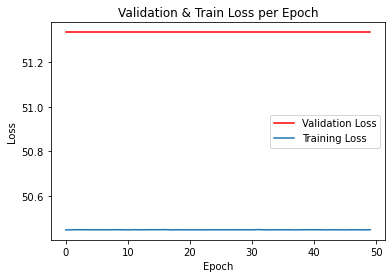

In [126]:
plt.plot(valid_epoch_loss_chart, label='Validation Loss', c='r')
plt.plot(train_epoch_loss_chart, label='Training Loss')
plt.title('Validation & Train Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig(f'./Plots/{name_of_data}___Validation_Training_Loss', dpi=300)

### Acc

In [94]:
plt.bar(x=['Training Set', 'Validation Set', 'Test Set'], height=[mp_train['acc'],mp_valid['acc'],mp_test['acc']])
plt.title('Accuracy for Train, Validation and Test Sets')
plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.text(-.25, .5, round(mp_train['acc'],3), c='white', size=20)
plt.text(-.25 + 1, .5, round(mp_valid['acc'],3), c='white', size=20)
plt.text(-.25 + 2, .5, round(mp_test['acc'],3), c='white', size=20)
plt.savefig(f'./Plots/{name_of_data}___ACC', dpi=300)

NameError: name 'mp_train' is not defined